In [2]:
"""
This file is part of the conclusion work of my MBA studies on Data Science and
Analytics. Intention of this is to automate download of unstructured data from YouTube
transcripts and turn it into structured data.

It produces a dataframe using the TF-IDF matrix generated from the transcripts data
indexed by date and limited by the experiment date ('2022-05-20 00:00:00').

Note that part of the code used by some cells below was fairly inspired on other sources
which are well referenced on each respective cell.

@author: Rafael Simionato
"""

import json
import pandas as pd

import pickle

import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import collections

# This script uses Google API client to get YouTube data.
# For installation support see complete details at Google API client page:
#   - https://github.com/googleapis/google-api-python-client
#       - pip install google-api-python-client
# For futher assistence please check these videos for a good reference
# on the complete setup and usage process
#   - https://www.youtube.com/watch?v=th5_9woFJmk&t=167s
#   - https://www.youtube.com/watch?v=RgtsBdeQ4Vc
from googleapiclient.discovery import build

# Following library is used to download a YouTube video transcript
#   - https://github.com/jdepoix/youtube-transcript-api
# To install it, use following command:
#   - pip install youtube_transcript_api
from youtube_transcript_api import YouTubeTranscriptApi

# Edit file youtube-scraper.config adding your key to use Google APIs
import configparser
parser = configparser.ConfigParser()
parser.read_file(open(r'youtube-scraper.config'))
api_key = parser.get('keystore', 'api_key')

youtube = build('youtube', 'v3', developerKey = api_key)

In [2]:
# This is the reference for Pablo Spyer YouTube channel
# https://www.youtube.com/channel/UCWdN619d_Ms-_Bq9OyR8fcA/videos

response_channels = youtube.channels().list(
        part = 'contentDetails',
        id = 'UCWdN619d_Ms-_Bq9OyR8fcA'
    ).execute()

uploaded_playlist_id = response_channels.get('items')[0]['contentDetails']['relatedPlaylists']['uploads']

print(uploaded_playlist_id)

UUWdN619d_Ms-_Bq9OyR8fcA


In [3]:
MAX_BATCH_SIZE = 50

# This is to limit the max iterations on getting video titles list. For testing,
# you may set it low. For prod, set it as big as you need. Keep in mind it will
# look back in the past (MAX_BATCH_SIZE x nextPageTokenCount) times and may stop
# earlier if it get all videos from the playlist.
nextPageTokenCount = 100

In [4]:
# Part of the code in this cell was inspired by the following reference:
#   [Python Project] Create a YouTube Channel Videos Scraper with Python | Part 1
#   https://www.youtube.com/watch?v=RgtsBdeQ4Vc

try:

    response_playlistItems = youtube.playlistItems().list(
            part = 'contentDetails',
            playlistId = uploaded_playlist_id,
            maxResults = MAX_BATCH_SIZE
        ).execute()

    playlistItems = response_playlistItems['items']
    nextPageToken = response_playlistItems.get('nextPageToken')

    while nextPageToken and nextPageTokenCount > 0:
        response_playlistItems = youtube.playlistItems().list(
                part = 'contentDetails',
                playlistId = uploaded_playlist_id,
                maxResults = MAX_BATCH_SIZE,
                pageToken = nextPageToken
            ).execute()
    
        playlistItems.extend(response_playlistItems['items'])
        nextPageToken = response_playlistItems.get('nextPageToken')
        nextPageTokenCount = nextPageTokenCount - 1

except Exception as e:

    print('General error!' + e)

print("There were identified " + str(len(playlistItems)) + " video IDs.")

# Defining the limit date for the experiments
videos = tuple(item['contentDetails'] for item in playlistItems \
    if item['contentDetails']['videoPublishedAt'] < '2022-05-21T00:00:00Z')

print("There were identified " + str(len(videos)) + " video IDs eligible for the experiments.")

try:

    videos_detail = []

    for batch in range(0, len(videos), MAX_BATCH_SIZE):

        vbatch = videos[batch: batch + MAX_BATCH_SIZE]
        
        response_videos = youtube.videos().list(
                id = ','.join(list(map(lambda vId:vId['videoId'], vbatch))),
                part = 'snippet',
                maxResults = MAX_BATCH_SIZE
            ).execute()

        for v in response_videos['items']:
            videos_detail.append(v)

except Exception as e:

    print('General error!' + e)

# Building a dataframe with columns id, publishedAt and title
df_snippet = pd.DataFrame([x['snippet'] for x in videos_detail])
df_others = pd.DataFrame(videos_detail).drop(columns=['snippet'])
df = pd.concat([df_others[['id']], df_snippet[['publishedAt', 'title']]], axis=1)
print(df.shape)
df.head(5)

There were identified 1223 video IDs.
There were identified 1162 video IDs eligible for the experiments.
(1162, 3)


,id,publishedAt,title
0,hXHsS3JsZ0c,2022-05-20T22:11:06Z,Sextouro - o Resumo da semana econômica no con...
1,T40Kej-sDic,2022-05-20T11:00:41Z,Minuto Touro de Ouro com Pablo Spyer - 20/05/22
2,cBa_EHXveeM,2022-05-19T22:22:36Z,Fechamento Touro de Ouro com Pablo Spyer - o T...
3,jUu--4vAFlc,2022-05-19T10:45:51Z,Minuto Touro de Ouro com Pablo Spyer - 19/05/22
4,CMvUHU7VzaE,2022-05-18T22:02:51Z,Fechamento Touro de Ouro com Pablo Spyer - o T...


In [5]:
filter_minuto = (
    'minuto com  pablo',
    'minuto touro',
    'mimuto touro',
    #'minuto touro de ouro',
    #'minuto touro de￼ ouro',
    #'minuto touro deo ouro',
    'minuto￼ touro',
    'minuto￼ touro de ouro',
    'minuto extraordinário',
    #'minuto extraordinário touro',
    #'minuto extraordinário touro de ouro'
    'minuto touronde',
    'minutotouro',
    'minuto economico',
    'minuto econômico',
    'minuto ecômico',
    'minuto pablo spyer',
	'minuto urgente')

filter_minuto = '|'.join([str(item) for item in (filter_minuto)])
filter_fechamento = 'fechamento touro de'
filter_sextou = 'sextou'

filter_minuto_fechamento_sextou = filter_minuto + '|' + filter_fechamento + '|' + filter_sextou
print(filter_minuto_fechamento_sextou)

df_filtered = df[df['title'].str.lower().str.strip().str.contains(filter_minuto_fechamento_sextou)]
df_filtered_out = df[~df['title'].str.lower().str.strip().str.contains(filter_minuto_fechamento_sextou)]

print(df_filtered.shape)
print(df_filtered_out.shape)

minuto com  pablo|minuto touro|mimuto touro|minuto￼ touro|minuto￼ touro de ouro|minuto extraordinário|minuto touronde|minutotouro|minuto economico|minuto econômico|minuto ecômico|minuto pablo spyer|minuto urgente|fechamento touro de|sextou
(962, 3)
(200, 3)


In [6]:
filter_out = ('de frente com o touro', 'agenda econômica', 'minuto agro', 'especial de férias', 'agenda touro de ouro', 'novo actros')
print(df_filtered_out[~df_filtered_out['title'].str.lower().str.strip().str.startswith(filter_out)].shape)
df_filtered_out_filtered = df_filtered_out[~df_filtered_out['title'].str.lower().str.strip().str.startswith(filter_out)]
df_filtered_out_filtered

(120, 3)


,id,publishedAt,title
151,cP8j1T3PLPQ,2022-02-22T12:11:24Z,O ministro Paulo Guedes ganha um Touro de Ouro...
197,gTpvWeXXmM8,2022-01-26T20:03:52Z,A caminho da reestreia do Fenômeno no Cruzeiro...
224,SwdSXsKGyjM,2022-01-01T00:39:51Z,"Feliz 2022, Brasil ! Com Kallyna Sabino"
230,MSUUqMatVCk,2021-12-25T17:08:12Z,Feliz Natal 🎄
279,QPuVYPvUhWI,2021-11-24T01:18:19Z,💛
...,...,...,...
1156,hNOTu0SKYDk,2019-10-22T11:49:34Z,22 October 2019
1158,lWkruiMEF-0,2019-10-11T15:15:07Z,Minuto Matinal dia 10 10 19
1159,6E5HyGRodVg,2017-05-19T10:14:51Z,Pablo Spyer Diretor da Corretora Mirae trading...
1160,jYkxiGxaYOo,2017-05-19T10:11:32Z,Corretora MIRAE em dia de Cirquit Breaker . Ma...


In [7]:
def getVideoTranscript(vId):

    joint_transcript = ''

    try:
        transcript = YouTubeTranscriptApi.get_transcript(vId, languages=['pt'])
        joint_transcript = ' '.join([ t['text'] for t in transcript ])
        
    except:
        print("An exception occurred!")
        joint_transcript = '>>> ERROR <<<'

    print('.', end = " ")

    return joint_transcript

In [8]:
print(df_filtered.shape)

df_filtered_minuto = df_filtered[df_filtered['title'].str.lower().str.strip().str.contains(filter_minuto)]
df_filtered_minuto = df_filtered_minuto[~df_filtered_minuto['title'].str.lower().str.strip().str.contains('agro')]
print(df_filtered_minuto.shape)

df_filtered_fechamento = df_filtered[df_filtered['title'].str.lower().str.strip().str.contains(filter_fechamento)]
print(df_filtered_fechamento.shape)

df_filtered_sextou = df_filtered[df_filtered['title'].str.lower().str.strip().str.contains(filter_sextou)]
print(df_filtered_sextou.shape)

(962, 3)
(574, 3)
(268, 3)
(109, 3)


In [9]:
df_filtered_transcript = pd.DataFrame(df_filtered_minuto)

df_filtered_transcript = df_filtered_transcript.reset_index(drop=True)

df_filtered_transcript['publishedAt'] = pd.to_datetime(df_filtered_transcript['publishedAt'])
df_filtered_transcript['publishedAt_YMD'] = df_filtered_transcript['publishedAt'].dt.strftime('%Y%m%d')
df_filtered_transcript = df_filtered_transcript.sort_values('publishedAt')
df_filtered_transcript = df_filtered_transcript.reset_index(drop=True)

print(df_filtered_transcript.shape)
df_filtered_transcript.head(5)

(574, 4)


,id,publishedAt,title,publishedAt_YMD
0,yjFOE-Q8Vd4,2019-10-21 12:22:37+00:00,Minuto Econômico com Pablo Spyer 21/10/2019,20191021
1,XDtNspilWEo,2019-10-23 10:15:34+00:00,Minuto Econômico com Pablo Spyer O Touro de Ou...,20191023
2,eAW_oqEDbBY,2019-10-24 10:01:27+00:00,Minuto Econômico com Pablo Spyer O Touro de Ou...,20191024
3,-VYciROsM_U,2019-10-25 09:58:41+00:00,Minuto Econômico com Pablo Spyer o Touro de Ou...,20191025
4,PaGhdL_wmFY,2019-10-28 11:26:19+00:00,Minuto Econômico com Pablo Spyer 28/10/2019,20191028


In [10]:
# ATTENTION: Only run this cell if you want to update your dataset as it takes more than 10 minutes
# to complete the download process.
df_filtered_transcript['transcript'] = df_filtered_transcript['id'].map(lambda x: getVideoTranscript(x))
df_filtered_transcript.head(5)

# Here at this point we should have a DataFrame with plent of transcripts. So let us save it to a pickle
# file to restart working from this point on whenever needed.
with open('./data/filtered_dataset/df_filtered_transcript.pkl', 'wb') as f:
    pickle.dump(df_filtered_transcript, f)

del df_filtered_transcript

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . An exception occurred!
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . An exception occurred!
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . An exception occurred!
. . . . . . . . . . . . . . . . . . . . . . . . . An exception occurred!
. . . . An exception occurred!
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . An exception occurred!
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . An exception occurred!
. . . . . . . . . . An exception occurred!
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . An exception occurred!
. . . . . . . . . . An exception occurred!
. An exception occurred!
. . An exception occurred!
. . . . . . . . . . . . . . . . . . . . . . . . . An e

In [3]:
# And reload df_filtered_transcript with all previous downloaded of transcripts.
with open('./data/filtered_dataset/df_filtered_transcript.pkl', 'rb') as f:
   df_filtered_transcript = pickle.load(f)

print(df_filtered_transcript.shape)
df_filtered_transcript.head(5)

(574, 5)


,id,publishedAt,title,publishedAt_YMD,transcript
0,yjFOE-Q8Vd4,2019-10-21 12:22:37+00:00,Minuto Econômico com Pablo Spyer 21/10/2019,20191021,bom dia brasil e boa semana nesta semana que a...
1,XDtNspilWEo,2019-10-23 10:15:34+00:00,Minuto Econômico com Pablo Spyer O Touro de Ou...,20191023,o dia brasil sobre ele aqui dentro uma reforma...
2,eAW_oqEDbBY,2019-10-24 10:01:27+00:00,Minuto Econômico com Pablo Spyer O Touro de Ou...,20191024,o brasil não tem como estar em madrid parece q...
3,-VYciROsM_U,2019-10-25 09:58:41+00:00,Minuto Econômico com Pablo Spyer o Touro de Ou...,20191025,bom dia brasil hoje é sexta feira ontem o gove...
4,PaGhdL_wmFY,2019-10-28 11:26:19+00:00,Minuto Econômico com Pablo Spyer 28/10/2019,20191028,bom dia brasil e boa semana é semana de superq...


In [4]:
# As function getVideoTranscript may throw an exception, it is mandatory treat it before going on
df_filtered_transcript_error = df_filtered_transcript[df_filtered_transcript['transcript'] == '>>> ERROR <<<']
df_filtered_transcript_error.shape

for i in df_filtered_transcript_error.index:
    #print(df_filtered_transcript.loc[i, 'transcript'])
    df_filtered_transcript.loc[i, 'transcript'] = ' '

In [5]:
# This is to find and merge all transcripts for videos released in a same given day

df_filtered_transcript_dup = df_filtered_transcript[ \
    df_filtered_transcript.duplicated(subset=['publishedAt_YMD'])].sort_values('publishedAt_YMD')

print(df_filtered_transcript.shape)
print(df_filtered_transcript_dup.shape)

for dup_date in df_filtered_transcript_dup['publishedAt_YMD'].drop_duplicates():
    df_aux = df_filtered_transcript[df_filtered_transcript['publishedAt_YMD']==dup_date].sort_values('publishedAt')
    transcript_joint = ' '.join(df_aux['transcript'].values)
    remove_it = False
    for i in df_aux.index:
        if remove_it == False:
            df_filtered_transcript.at[i, 'transcript'] = transcript_joint
        else:
            df_filtered_transcript = df_filtered_transcript.drop(i)
        remove_it = True

df_filtered_transcript = df_filtered_transcript.reset_index(drop=True)
print(df_filtered_transcript.shape)

(574, 5)
(22, 5)
(552, 5)


In [6]:
nltk.download('stopwords')
stopset = stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\r.simionato\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def check_word(word, stopwords):
    if word not in (stopwords) and len(word)>1:
        return True
    else:
        return False

def filter_stopwords(df, stopwords):
    df_filtered = pd.DataFrame(df)
    df_filtered['transcript_without_stopwords'] = df['transcript'].apply(lambda x: \
        ' '.join([word for word in x.lower().split() if check_word(word, stopwords)]))
    return df_filtered

In [8]:
# Part of the code in this cell was inspired by the following references:
#   Word cloud
#   https://www.geeksforgeeks.org/generating-word-cloud-python
# 
#   Word count and histogram
#   https://datascienceparichay.com/article/python-frequency-of-each-word-in-string

def make_word_cloud_and_histogram(words):

    corpus_words = ''

    for val in words:
        tokens = str(val).split()
        corpus_words += " ".join(tokens) + " "

    corpus_words = corpus_words.strip()

    wordcloud = WordCloud(
                          width = 800, height = 900,
                          background_color ='white',
                          min_font_size = 10).generate(corpus_words)
    
    fig, ((ax2), (ax1)) = plt.subplots(figsize=(9, 5), nrows=1, ncols=2)

    # plot the WordCloud image
    ax1.imshow(wordcloud)
    ax1.axis("off")
    ax1.set_title('Nuvem de palavras')
    plt.tight_layout(pad = 0)

    corpus_words_counts = collections.Counter(corpus_words.split(" "))
    df_corpus_word_count = pd.DataFrame.from_records(
        corpus_words_counts.most_common(), columns=['word','count'])

    MAX_FEATURES_PLOT = 30

    # plot horizontal bar plot
    df_corpus_word_count.sort_values(by='count', ascending=False) \
                        .head(MAX_FEATURES_PLOT).sort_values(by='count') \
                        .plot.barh(x="word", y="count", ax=ax2)
    # set the title
    ax2.set_xlabel('Frequência')
    ax2.set_ylabel('Palavras')
    ax2.set_title('Histograma de palavras mais frequentes no corpus')

    plt.show()

    return df_corpus_word_count

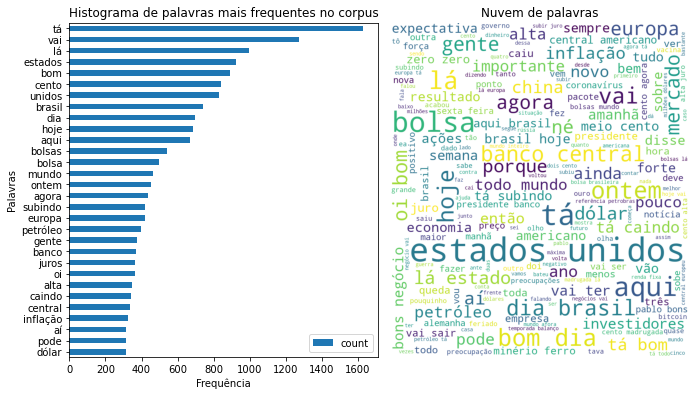

In [9]:
df_filtered_transcript_without_stopwords = filter_stopwords(df_filtered_transcript, stopset)
df_corpus_word_count = make_word_cloud_and_histogram(
    df_filtered_transcript_without_stopwords['transcript_without_stopwords'])

In [10]:
# Then from the analisys, we may define a custom stopset, append it to the original one and run all again
# The special word 'cento' may be removed too as it refers to 'porcento' (%)
stopset_custom = ['tá', 'vai', 'lá', 'oi', 'bom', 'dia', 'brasil', 'gente', 'aí', 'né', 'pablo', 'cento']
stopset_custom = stopset + stopset_custom

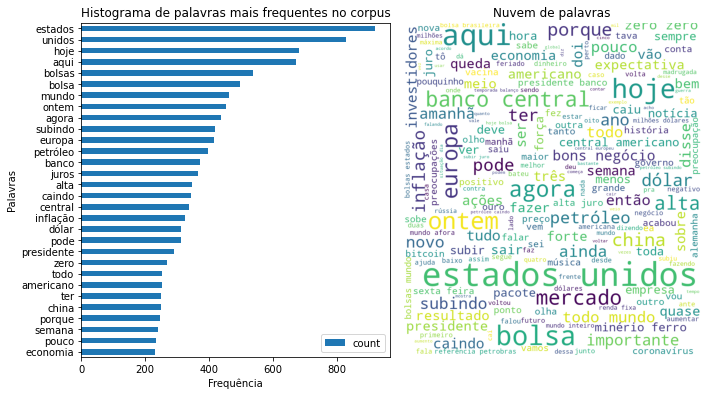

In [11]:
df_filtered_transcript_without_stopwords = filter_stopwords(df_filtered_transcript, stopset_custom)
df_corpus_word_count = make_word_cloud_and_histogram(
    df_filtered_transcript_without_stopwords['transcript_without_stopwords'])

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

MAX_FEATURES_TF_IDF = 150

vectorizer = TfidfVectorizer(analyzer = 'word', token_pattern = r"(?u)\S\S+", max_features = MAX_FEATURES_TF_IDF)
tfidf_matrix = vectorizer.fit_transform(df_filtered_transcript_without_stopwords['transcript_without_stopwords'])
df_tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns = vectorizer.get_feature_names_out())

print(df_tfidf_matrix.shape)

df_filtered_plublishedat_tfidf = pd.DataFrame(df_filtered_transcript_without_stopwords[['publishedAt_YMD']])
df_filtered_plublishedat_tfidf = df_filtered_plublishedat_tfidf.join(df_tfidf_matrix)

print(df_filtered_plublishedat_tfidf.shape)

with open('./data/filtered_dataset/df_filtered_plublishedat_tfidf.pkl', 'wb') as f:
    pickle.dump(df_filtered_plublishedat_tfidf, f)

(552, 150)
(552, 151)


In [15]:
# This is just a step to check if all words (MAX_FEATURES_TF_IDF) came into TF-IDF matrix
temp1 = set(df_corpus_word_count.sort_values(by='count', ascending=False).head(MAX_FEATURES_TF_IDF)['word'].values)
temp2 = set(vectorizer.get_feature_names_out())
list(set(temp1) - set(temp2))

[]